## Pyro, Bayesian analysis, and attempt on BCRF (Qi et al 2005)

In [1]:
import pyro
from pyro.distributions import Normal, Uniform
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, EmpiricalMarginal, TraceEnum_ELBO, JitTraceEnum_ELBO
from pyro.infer.mcmc import MCMC, NUTS
from pyro.optim import Adam
from pyro.util import ignore_jit_warnings
from pyro.contrib.autoguide import AutoDelta

import torch
import torch.nn as nn

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

In [2]:
DATA_URL = "https://d2fefpcigoriu7.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

In [3]:
data = torch.tensor(df.values, dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

In [4]:
def model(x_data, y_data):
    n = len(x_data)

    # w, b, sigma parameter is outside of plate, independent of N
    weight = pyro.sample("w", dist.Normal(torch.zeros(1, 2), torch.ones(1, 2)))
    bias = pyro.sample("b", dist.Normal(torch.tensor([[0.]]), torch.tensor([[100.]])))
    sigma = pyro.sample("epsilon", Uniform(0., 10.))

    with pyro.plate("map", n):
        mu = (x_data[:, 0] * weight[0][0] + x_data[:, 1] * weight[0][1] + bias).squeeze(1)
        yhat = pyro.sample("yhat", Normal(mu, sigma), obs=y_data)
        return yhat

## Stochastic Variational Inference with spherical gaussian on linear regression

In [5]:
from pyro.contrib.autoguide import AutoDiagonalNormal
mean_field_guide = AutoDiagonalNormal(model)

# inject callables into SVI instantiation
svi = SVI(model, mean_field_guide, Adam({"lr": 0.03}), loss=Trace_ELBO(), num_samples=1000)

In [6]:
pyro.clear_param_store()
for j in range(2000):
    loss = svi.step(x_data, y_data)
    if j % 500 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 33.0613
[iteration 0501] loss: 8.4615
[iteration 1001] loss: 5.8251
[iteration 1501] loss: 4.9313


In [7]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

auto_loc tensor([  4.5228,   7.9894, -12.0189,   3.0400], requires_grad=True)
auto_scale tensor([0.8343, 0.4173, 0.7929, 0.4044], grad_fn=<AddBackward0>)


## No-U-turn Sampler

In [8]:
pyro.clear_param_store()

nuts = NUTS(model)
sampler = MCMC(nuts,
               num_samples=600,
               num_chains=1,
               # burn-in
               warmup_steps=100)
traces = sampler.run(x_data, y_data)

Sample: 100%|██████████| 700/700 [00:30<00:00, 22.79it/s, step size=4.48e-02, acc. prob=0.936]


In [9]:
posteriors = traces.marginal(["w", "b", "epsilon"])

In [10]:
a = posteriors.empirical["epsilon"]

In [11]:
def get_marginal(traces, sites):
    return EmpiricalMarginal(traces, sites)._get_samples_and_weights()[0].detach().cpu().numpy()

In [12]:
posterior_weight = posteriors.empirical["w"]
posterior_bias = posteriors.empirical["b"]
posterior_epsilon = posteriors.empirical["epsilon"]

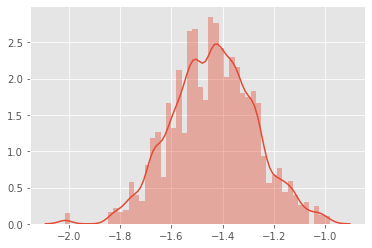

In [13]:
sns.distplot(posterior_weight((10000, )).squeeze(1)[:, 0])

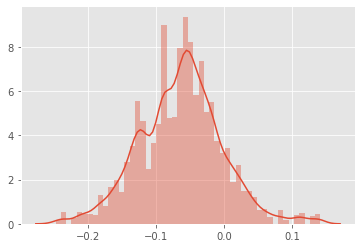

In [14]:
sns.distplot(posterior_weight((10000, )).squeeze(1)[:, 1])

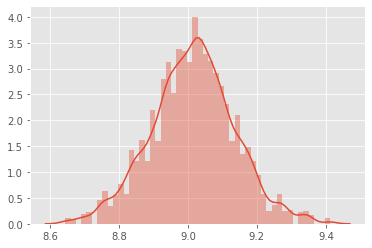

In [15]:
sns.distplot(posterior_bias((10000, )))

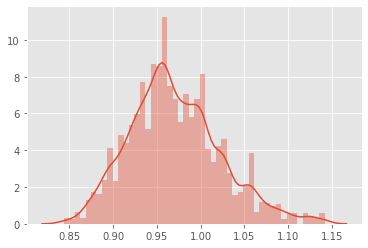

In [16]:
sns.distplot(posterior_epsilon((10000, )))

## vanila HMM before going BCRF (Qi et al. 2005)

In [17]:
# adopted from HMM tutorials at: https://pyro.ai/examples/hmm.html

In [17]:
# Pyro's poutine handles effects 
from pyro import poutine
import dmm.polyphonic_data_loader as poly

In [18]:
class MockArgs():
    num_steps=50
    hidden_dim=16
    nn_dim=48
    batch_size=32
    nn_channels=2
    learning_rate=0.05
    truncate=None
    print_shapes=False
    jit=True
    cuda=True
    raftery_parameterization=True
args = MockArgs()

In [19]:
if args.cuda:
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [25]:
# JSB Chorales dataset, pianos keys pressed out of 88 keys.
# Modeling Temporal Dependencies in High-Dimensional Sequences: Application to Polyphonic Music Generation and Transcription
# http://www-etud.iro.umontreal.ca/~boulanni/icml2012
data = poly.load_data(poly.JSB_CHORALES)

In [26]:
sequences = data['train']['sequences']
lengths = data['train']['sequence_lengths']

In [27]:
# only some keys of this piano were pressed, some not, so reduce dimension of the sequence
notes_pressed = ((sequences == 1).sum(0).sum(0) > 0)

In [28]:
sequences = sequences[:, :, notes_pressed]

In [29]:
if args.truncate:
    lengths.clamp_(max=args.truncate)
    sequences = sequences[:, :args.truncate]
num_observations = float(lengths.sum())

In [30]:
def model_1(sequences, lengths, args, batch_size=None, include_prior=True):
    # Sometimes it is safe to ignore jit warnings. Here we use the
    # pyro.util.ignore_jit_warnings context manager to silence warnings about
    # conversion to integer, since we know all three numbers will be the same
    # across all invocations to the model.
    with ignore_jit_warnings():
        num_sequences, max_length, data_dim = map(int, sequences.shape)
        assert lengths.shape == (num_sequences, )
        assert lengths.max() <= max_length

    with poutine.mask(mask=include_prior):
        # to_event seperates n right-most dimension as event dimension from batch dimension.
        # transition probability p(y_t | y_t-1)
        probs_x = pyro.sample("probs_x", dist.Dirichlet(0.9 * torch.eye(args.hidden_dim) + 0.1).to_event(1))
        # emission probability p(x_t | y_t)
        probs_y = pyro.sample("probs_y", dist.Beta(0.1, 0.9).expand([args.hidden_dim, data_dim]).to_event(2))

    # nodes_plate in shape [DATA_DIM], in this case 51 dimension of each observation
    nodes_plate = pyro.plate("nodes", data_dim, dim=-1)
    # We subsample batch_size items out of num_sequences items. Note that since
    # we're using dim=-1 for the notes plate, we need to batch over a different
    # dimension, here dim=-2.

    with pyro.plate("sequences", size=num_sequences, subsample_size=batch_size, dim=-2) as batch:
        # here batch is indice of subsampled, in shape [BATCH_SIZE, 1].
        batch_lengths = lengths[batch]

        x = 0
        for t in pyro.markov(range(max_length if args.jit else batch_lengths.max())):
            with poutine.mask(mask=(t < batch_lengths).unsqueeze(-1)):
                hidden_states = probs_x[x]
                x = pyro.sample("x_{}".format(t), dist.Categorical(hidden_states), infer={"enumerate": "parallel"})
                # x is sampled from categorical distribution of [0, 1, 2, ..., hidden_dim], in batch
                # x is the hidden states in shape [BATCH_SIZE] at markov process at time t, of latent variable probs_x
                # nodes_plate is plate of N := data_dim
                with nodes_plate:
                    # y in size [BATCH_SIZE, DATA_DIM], generated by hidden_states at time t, which is x.
                    probs_y_given_hidden_state = probs_y[x.squeeze(-1)]
                    # bernoulli distribution because the music tones of data_dim 51 dimension is binary
                    y = pyro.sample("y_{}".format(t), dist.Bernoulli(probs_y_given_hidden_state),
                                    # observed these y at t
                                    obs=sequences[batch, t])

In [31]:
model = model_1

In [32]:
from pyro.contrib.autoguide import AutoDelta, AutoDiagonalNormal
# Delta distribution for constrained MAP inference
guide = AutoDelta(poutine.block(model, expose_fn=lambda msg: msg["name"].startswith("probs_")))

In [33]:
elbo = JitTraceEnum_ELBO(max_plate_nesting=2, strict_enumeration_warning=True)
optim = Adam({'lr': 1e-3})
svi = SVI(model, guide, optim, elbo)

In [34]:
pyro.clear_param_store()
for step in range(args.num_steps):
    loss = svi.step(sequences,
                    lengths, args=args, batch_size=args.batch_size, include_prior=False)
    if not step % 10:
        print('{: >5d}\t{}'.format(step, loss / num_observations))

    0	20.177627290504816
   10	21.912485514594046
   20	19.304469653074527
   30	20.01022126457594
   40	21.36708282030854


## Applying Turk data 20190716

In [35]:
num_sequences, max_length, data_dim = map(int, sequences.shape)

In [20]:
import string
from pathlib import Path
from typing import Union, Tuple, Iterable
from smart_open import open

In [21]:
def simple_bioes_parser(path: Union[Path, str]) -> Tuple:
    """simple parser for BIOES to BIO and remove puntuations"""
    document_container = []
    sequence_container = []
    length_container = []

    with open(path, "r") as f:
        for line in f.readlines():
            length = len(sequence_container)
            line = line.rstrip()

            # naively detect sentence boundary
            if len(line) < 2:
                if length > 0:
                    length_container.append(length)
                    document_container.append(list(zip(*sequence_container)))
                    sequence_container = []
                    continue

            try:
                word, entity_type = line.split('\t')
            except ValueError:
                continue

            if word in string.punctuation:
                continue

            # skip lemmatization for later.
            word = word.lower()

            if "-" in entity_type:
                a, b = entity_type.split("-")
                a = a.translate(str.maketrans("ES", "IB"))
                entity_type = "-".join([a, b])

            sequence_container.append(tuple([word, entity_type]))

        for d, l in zip(document_container, length_container):
            tokens, ents = d
            assert len(tokens) == l
            assert len(ents) == l

    return document_container

In [187]:
raw_documents = simple_bioes_parser("./data/turk_ner_20190716.txt")
raw_lengths = [len(d[0]) for d in raw_documents]

In [188]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"

word_to_ix = {}
tag_to_ix = {}
for sentence, tags in raw_documents:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
    for tag in tags:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

# tag_to_ix[START_TAG] = len(tag_to_ix)
# tag_to_ix[STOP_TAG] = len(tag_to_ix)

In [189]:
tokenized_sents = [i[0] for i in raw_documents]

In [190]:
from gensim.corpora import Dictionary

In [191]:
dct = Dictionary(tokenized_sents)
dct.filter_extremes()
dct.compactify()
# unknown token last in the vocabulary
dct.token2id["UNK"] = len(dct)

In [192]:
data_dim = len(dct)

In [193]:
e = torch.eye(data_dim, dtype=torch.long, requires_grad=False)

In [194]:
args.hidden_dim = len(tag_to_ix)

In [195]:
tokenized_sequences, tokenized_entities = list(zip(*raw_documents))

In [196]:
def tensorize_sentence(seq):
    idxs = dct.doc2idx(seq, unknown_word_index=-1)
    return torch.tensor(idxs, dtype=torch.long)

In [197]:
def tensorize_entities(seq, dictionary):
    idxs = [tag_to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

In [198]:
idx_sents = list(map(tensorize_sentence, tokenized_sequences))

In [199]:
idx_ents = list(map(lambda x: tensorize_entities(x, tag_to_ix), tokenized_entities))

In [200]:
lengths = torch.tensor([len(d[0]) for d in raw_documents])

In [215]:
def BHMM(sequences, targets, lengths, args, include_prior=True):
    with ignore_jit_warnings():
        num_sequences = len(sequences)
        max_length = max(lengths)
        data_dim = args.data_dim
        assert lengths.shape == (num_sequences, )
        assert lengths.max() <= max_length

    with poutine.mask(mask=include_prior):
        # to_event seperates n right-most dimension as event dimension from batch dimension.
        # transition probability p(y_t | y_t-1)
        probs_x = pyro.sample("probs_x", dist.Dirichlet(0.9 * torch.eye(args.hidden_dim) + 0.1).to_event(1))
        # emission probability p(x_t | y_t)
        probs_y = pyro.sample("probs_y", dist.Beta(0.1, 0.9).expand([args.hidden_dim, data_dim]).to_event(2))

    # nodes_plate in shape [DATA_DIM], in this case size of vocabulary
    nodes_plate = pyro.plate("nodes", data_dim, dim=-1)
    # We subsample batch_size items out of num_sequences items. Note that since
    # we're using dim=-1 for the notes plate, we need to batch over a different
    # dimension, here dim=-2.

    with pyro.plate("sequences", size=num_sequences, subsample_size=args.batch_size, dim=-2) as batch:
        # here batch is indice of subsampled, in shape [BATCH_SIZE, 1].
        batch_lengths = lengths[batch]
        batch_sequences = make_seq_batch(batch, data=sequences, identity=e)
        batch_targets = make_ent_batch(batch, data=targets)

        # start index of transition matrix for every sequence in the batch
        x = 0
        for t in pyro.markov(range(max(batch_lengths))):
            with poutine.mask(mask=(t < batch_lengths).unsqueeze(-1)):
                hidden_states = probs_x[x]
                x = pyro.sample("x_{}".format(t),
                                dist.Categorical(hidden_states),
                                infer={"enumerate": "parallel"},
                                obs=batch_targets[:, t])
                # x is sampled from categorical distribution of [0, 1, 2, ..., tag_size], in batch
                # x is the hidden states in shape [BATCH_SIZE] at markov process at time t, of latent variable probs_x
                # nodes_plate is plate of N := data_dim

                with nodes_plate:
                    # y in size [BATCH_SIZE, DATA_DIM], generated by hidden_states at time t, which is x.
                    probs_y_given_hidden_state = probs_y[x.squeeze(-1)]
                    # Categorical distribution for observable word generated from latent variable at z of certain value
                    y = pyro.sample("y_{}".format(t), dist.Categorical(probs_y_given_hidden_state),
                                    # observed these y at t)
                                    obs=batch_sequences[:, t, :])

In [216]:
def make_seq_batch(batch_index, data: Iterable, identity: torch.Tensor = None):
    data_dim = identity.shape[0]
    batch_data = [data[i] for i in batch_index]

    lengths = [d.shape[0] for d in batch_data]
    max_length = max(lengths)
    shape = [len(batch_index), max_length, data_dim]

    template = torch.zeros(*shape, dtype=torch.long)
    for k, tensor in enumerate(batch_data):
        template[k, :lengths[k]] = identity[tensor]

    return template

In [217]:
def make_ent_batch(batch_index, data: Iterable):
    batch_data = [data[i] for i in batch_index]
    lengths = [d.shape[0] for d in batch_data]
    max_length = max(lengths)
    template = torch.zeros(len(batch_index), max_length, dtype=torch.long)
    for k, tensor in enumerate(batch_data):
        template[k, :lengths[k]] = tensor
    
    return template

In [218]:
guide = AutoDelta(poutine.block(BHMM, expose_fn=lambda msg: msg["name"].startswith("probs_")))

In [219]:
elbo = JitTraceEnum_ELBO(max_plate_nesting=2, strict_enumeration_warning=True)
optim = Adam({'lr': 1e-3})
svi = SVI(BHMM, guide, optim, elbo)

In [220]:
class MockArgs():
    data_dim = len(dct)
    num_steps=50
    hidden_dim=len(tag_to_ix)
    nn_dim=48
    batch_size=64
    nn_channels=2
    learning_rate=0.05
    truncate=None
    print_shapes=False
    jit=True
    cuda=True
    raftery_parameterization=True

args = MockArgs()

In [221]:
pyro.clear_param_store()
for step in range(args.num_steps):
    loss = svi.step(idx_sents, idx_ents, lengths, args=args, include_prior=True)
    if not step % 10:
        print('{: >5d}\t{}'.format(step, loss / num_observations))

torch.Size([64])


ValueError: Shape mismatch inside plate('nodes') at site y_0 dim -1, 3233 vs 64
Trace Shapes:          
 Param Sites:          
Sample Sites:          
 probs_x dist | 18   18
        value | 18   18
 probs_y dist | 18 3233
        value | 18 3233
Trace Shapes:
 Param Sites:
Sample Sites:
Trace Shapes:
 Param Sites:
Sample Sites: